In [8]:
# Data managing
import glob
import pickle
import tqdm
import pandas as pd

# Computations
import numpy as np
import torch
import torch.nn as nn

# Data augmentation
import albumentations as A
import torchvision.transforms as transforms

# Image managing and visualization
import cv2
from cv2 import imread
from IPython.display import Image
import matplotlib.pyplot as plt

import sys
sys.path.insert(1, 'src/')
# Local modules
from src.SynthesEyes_dataloader import create_loader
from src.AverageMeter import AverageMeter
from src.utils import draw_histories

### Load data

In [9]:
listed_images = np.array(sorted(glob.glob('**/*.png',recursive=True)))
listed_data = np.array(sorted(glob.glob('**/*.pkl',recursive=True)))
print("images length : {}, data length : {}".format(len(listed_images), len(listed_data)))

images length : 11382, data length : 11382


In [10]:
train_dataloader, test_dataloader = create_loader(listed_images, listed_data)

10243it [00:05, 1994.28it/s]
1139it [00:00, 1964.42it/s]


### Setup device

It's either CPU or single GPU

In [11]:
use_gpu = True
device = "cuda" if use_gpu and torch.cuda.is_available() else "cpu"

print("Working device : ", end='')
if device == "cuda":
    print("GPU - {}".format(torch.cuda.get_device_name(0)))
    !nvidia-smi
else:
    print("CPU")

Working device : GPU - GeForce RTX 3060 Ti
Fri Dec 25 19:07:25 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.45.01    Driver Version: 455.45.01    CUDA Version: 11.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce RTX 306...  Off  | 00000000:08:00.0  On |                  N/A |
|  0%   49C    P8    24W / 200W |   1126MiB /  7981MiB |      5%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                             

## Hourglass network

Hourglass neural network first presented at [Stacked Hourglass Networks for Human Pose Estimation](https://arxiv.org/pdf/1603.06937.pdf) [1], this architecture tend to produce very precise results at Human Pose Estimation task.

It's also believed, that such neural network can hold pupil keypoints localization task, and it has been shown in [Learning to Find Eye Region Landmarks for Remote Gaze Estimation in Unconstrained Settings](https://arxiv.org/abs/1805.04771) [2]

Hourglass a pretty light-weight network, since it doesn't use any FC layers, which helps to achieve very small size of the model, but I'm not sure about GPU memory used during inference time.

It has following architecture :

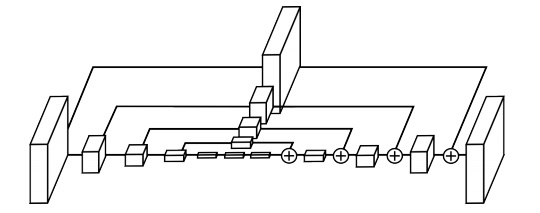

In [12]:
Image('hourglass_architecture.jpg')

In [13]:
def init_weights(layer):
    if isinstance(layer, nn.Conv2d):
        nn.init.kaiming_normal_(layer.weight)
        nn.init.zeros_(layer.bias)
    elif isinstance(layer, nn.Linear):
        nn.init.kaiming_normal_(layer.weight)
        nn.init.zeros_(layer.bias)
from src.hourglass import Hourglass

## EyePupilNet

This network will be used to extract heatmaps of pupil landmarks using similar approach to the one described in [2]


In [14]:
class EyePupilNet(nn.Module):
    def __init__(self, in_features=64, middle_features=32, residual_count=3, use_batchnorm=True):
        super(EyePupilNet, self).__init__()
        # (N, 3, 80, 120)
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=in_features, kernel_size=[3, 3], padding=[1, 1]),
            nn.ReLU()
        )
        # (N, 64, 80, 120)
        self.hourglass1= Hourglass(in_features=in_features, middle_features=middle_features, \
                                   residual_count=residual_count, use_batchnorm=use_batchnorm)
        self.hourglass2= Hourglass(in_features=in_features, middle_features=middle_features, \
                                   residual_count=residual_count, use_batchnorm=use_batchnorm)
        self.hourglass3= Hourglass(in_features=in_features, middle_features=middle_features, \
                                   residual_count=residual_count, use_batchnorm=use_batchnorm)
        # (N, 64, 80, 120)
        self.conv2 = nn.Conv2d(in_channels=in_features, out_channels=8, kernel_size=[1, 1])
    def forward(self, image):
        image = self.conv1(image)
        image = self.hourglass1(image)
        image = self.hourglass2(image)
        image = self.hourglass3(image)
        heatmaps = self.conv2(image)
        return heatmaps

## Approximate heatmaps generation

In [15]:
def generate_gaussian(height, width, x_center, y_center, sigma):
    x = torch.arange(height).reshape(height, 1).to(device)
    y = torch.arange(width).reshape(width, 1).T.to(device)
    gauss = torch.exp(-(x-x_center)**2/sigma).matmul(torch.exp(-(y - y_center) ** 2/sigma))
    return gauss

In [69]:
def gaussian_2d(shape, centre, sigma=1.0):
    """Generate heatmap with single 2D gaussian."""
    xs = torch.arange(0.5, shape[1] + 0.5, step=1.0).to(device)
    ys = torch.unsqueeze(torch.arange(0.5, shape[0] + 0.5, step=1.0), -1).to(device)
    alpha = -0.5 / (sigma**2)
    heatmap = torch.exp(alpha * ((xs - centre[0])**2 + (ys - centre[1])**2))
    return heatmap

In [70]:
def add(ax, image, heat_map, alpha=0.4, cmap='viridis'):
    height = image.shape[0]
    width = image.shape[1]
 
    # display
    ax.imshow(image.detach().cpu())
    ax.imshow(heat_map, alpha=alpha, cmap=cmap)

In [84]:
def create_heatmaps(pupil_landmarks, batch_size=32, height=80, width=120):
    # Since we have 8 landmarks, this number is fixed
    pupil_landmarks_amount = 8
    heatmaps = torch.empty(batch_size, pupil_landmarks_amount, height, width)
    for i in range(batch_size):
        for j in range(pupil_landmarks_amount):
            x = pupil_landmarks[i][2 * j]
            y = pupil_landmarks[i][2 * j + 1]
            heatmaps[i][j] = gaussian_2d((height, width), (x, y), sigma=1.00)
    return heatmaps.float().to(device)

In [85]:
def show_heatmaps(ax, eye, heatmaps):
    _,  H, W = heatmaps.shape
    heatmap = torch.zeros((H, W)).to("cpu")

    pupil_landmarks_amount = 8
    for idx in range(pupil_landmarks_amount):
        heatmap += heatmaps[idx]
    add(ax, eye, heatmap)

In [86]:
def show_test(model, test_loader, heatmaps_only=False, eye_only=False):
    model.eval()

    iterator = iter(test_loader)
    images, _, pupil_landmarks = next(iterator)
    
    N, M = 5, 5
    heatmaps_only = heatmaps_only
    eyes_only = eye_only
    assert N * M <= 32
    images = images[: N * M].to(device)
    pupil_landmarks = pupil_landmarks[:N * M].to(device)

    with torch.no_grad():
        predictions = model(images).detach().cpu()
    
    fig, ax = plt.subplots(ncols=N, nrows=M, figsize=(18, 18))
    for index in range(N * M):
        if heatmaps_only:
            ax[index // N, index % M].imshow(torch.sum(predictions[index], 0))
        elif eyes_only:
            ax[index // N, index % M].imshow(images[index].permute(1, 2, 0))
        elif N != 1 and M != 1:
            show_heatmaps(ax[index // N, index % M], images[index].permute(1, 2, 0), predictions[index])
        elif N == 1 ^ M != 1:
            show_heatmaps(ax[index], images[index], predictions[index])
        elif N == 1 and M == 1:
            show_heatmaps(ax, images[index], predictions[index])

In [87]:
def train(epoch, train_loader, model, optimizer, criterion, train_history):
    model.train()
    
    train_size = len(train_loader)
    meter = AverageMeter()
    for step, (images, _, pupil_landmarks) in enumerate(train_loader):
        optimizer.zero_grad()
        images = images.to(device)
        heatmaps = create_heatmaps(pupil_landmarks)
        
        predictions = model(images)
        
        assert predictions.shape == heatmaps.shape
        loss = criterion(predictions, heatmaps)
        loss.backward()   
        
        optimizer.step()
        
        meter.update(loss.item(), 1)
        if step % 50 == 0:
            print("Epoch : {} ({}/{}), loss : {:.2f} ({:.2f})".format(epoch, step, train_size, meter.val, meter.avg))
    train_history.append((epoch, meter.avg))

In [88]:
def test(epoch, test_loader, model, criterion, test_history):
    model.eval()

    meter = AverageMeter()
    test_size = len(test_loader)
    for step, (images, _, pupil_landmarks) in tqdm.tqdm(enumerate(test_loader)):
        images = images.to(device)
        pupil_landmarks = pupil_landmarks.to(device)

        bs = images.size(0)
        with torch.no_grad():
            heatmaps = create_heatmaps(pupil_landmarks, batch_size=bs)
            predictions = model(images)
            loss = criterion(predictions, heatmaps)
        meter.update(loss.item(), bs)
    print("Epoch {}, loss : {:.2f}".format(epoch, meter.avg))
    test_history.append((epoch, meter.avg))

In [89]:
def custom_loss(prediction, ground_truth):
    return torch.sum((prediction - ground_truth) ** 2)

In [90]:
train_history = []
test_history = []

def main(train_loader, test_loader, epochs, save_step):    
    model = EyePupilNet(in_features=64, middle_features=32, residual_count=3, use_batchnorm=True)
    model.to(device)
    model.apply(init_weights)
    
    optimizer = torch.optim.Adam(
        model.parameters(),
        lr=5e-4,
        betas=[0.9, 0.99],
        eps=1e-8
    )
    criterion = custom_loss
    scheduler = torch.optim.lr_scheduler.MultiStepLR(
        optimizer,
        milestones=[epochs - 25],
        gamma=1e-1
    )
    
    for epoch in range(1, epochs + 1):
        train(epoch, train_loader, model, optimizer, criterion, train_history)
        
        # Dirty hack to make tqdm work correctly
        print("Evaluating model on test set...")
        scheduler.step()
        
        test(epoch, test_loader, model, criterion, test_history)
        
        if epoch % save_step == 0:
            print("Saving the model...")
            state_dict = model.state_dict()
            torch.save(state_dict, "models/model_state_bn_{}.pth".format(epoch))
            print("Saved successfully")
        
    print("Training ended")

In [49]:
save_step = 20
epochs = 680
assert(epochs % save_step == 0)
main(train_dataloader, test_dataloader, epochs, save_step)

AttributeError: module 'torch' has no attribute 'expand_dims'

In [ ]:
# Clear cached memory after interuption
torch.cuda.empty_cache()

In [8]:
draw_histories(train_history, test_history)

NameError: name 'train_history' is not defined

In [18]:
model = EyePupilNet()
state_dict = torch.load('models/bn_sigma1_76_long/model_state_bn_500.pth')
model.load_state_dict(state_dict)
model.to(device)

EyePupilNet(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=[3, 3], stride=(1, 1), padding=[1, 1])
    (1): ReLU()
  )
  (hourglass1): Hourglass(
    (down_sample): Sequential(
      (0): MaxPool2d(kernel_size=[2, 2], stride=[2, 2], padding=0, dilation=1, ceil_mode=False)
      (1): Residual(
        (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv1): Sequential(
          (0): Conv2d(64, 32, kernel_size=[1, 1], stride=(1, 1))
          (1): ReLU()
        )
        (conv2): Sequential(
          (0): Conv2d(32, 32, kernel_size=[3, 3], stride=(1, 1), padding=[1, 1])
          (1): ReLU()
        )
        (conv3): Sequential(
          (0): Conv2d(32, 64, kernel_size=[1, 1], stride=(1, 1))
          (1): ReLU()
        )
      )
    )
  

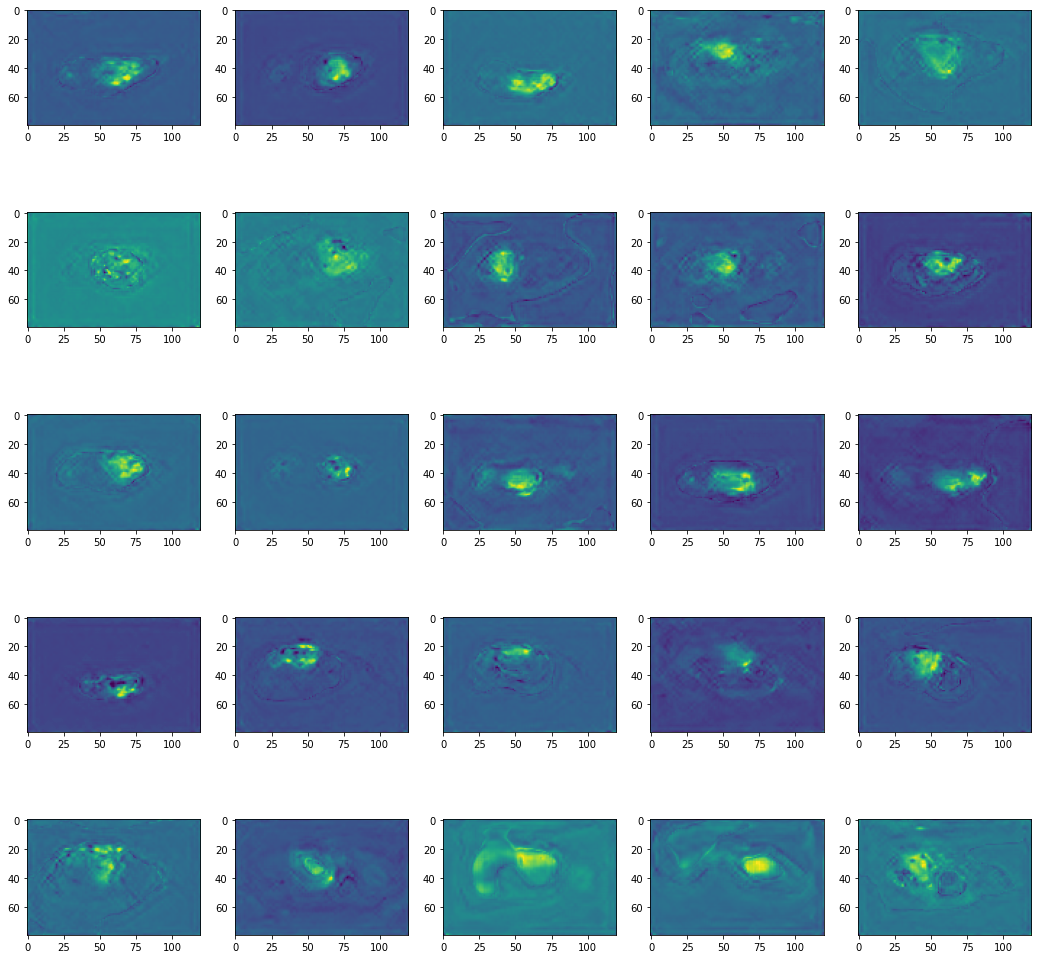

In [19]:
show_test(model, test_dataloader, heatmaps_only=True)

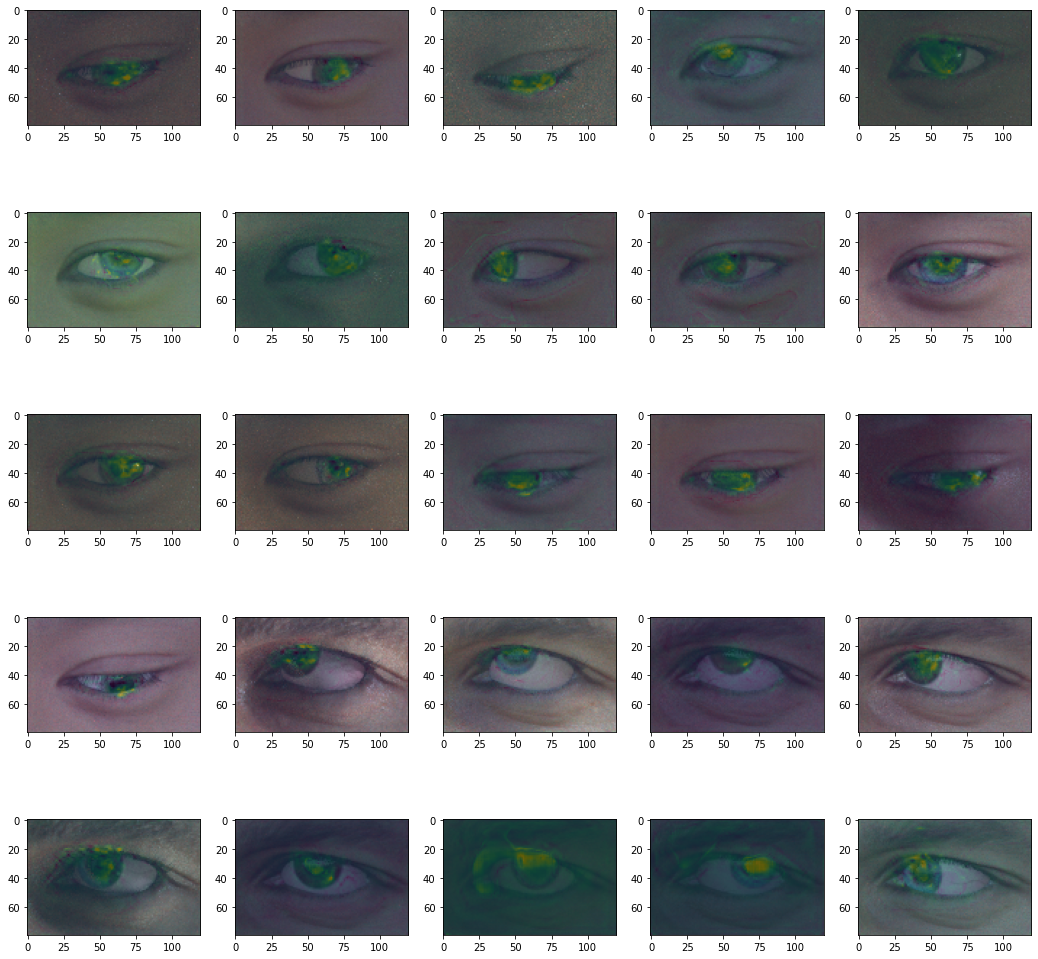

In [20]:
show_test(model, test_dataloader, eye_only=False)

## Loss generation for training EyePupilNet

Let's test `create_heatmaps` function in order to check, if it generates ground-truth heatmaps correctly

In [91]:
iterator = iter(test_dataloader)
images, _, pupil_landmarks = next(iterator)

In [92]:
eye = images[0].permute(1, 2, 0)
eye_pupil_landmarks = pupil_landmarks[0].reshape(1, -1)
print(eye.shape, eye_pupil_landmarks.shape)

torch.Size([80, 120, 3]) torch.Size([1, 16])


In [93]:
hm = create_heatmaps(eye_pupil_landmarks, batch_size = 1)
print(hm.shape)

torch.Size([1, 8, 80, 120])


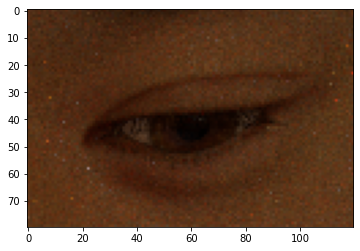

In [94]:
plt.imshow(eye)

### Generated heatmaps

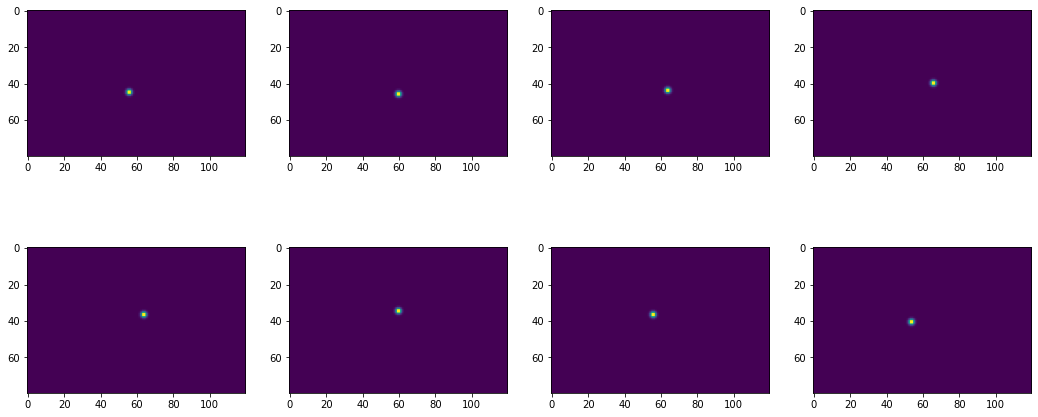

In [95]:
N, M = 2, 4
fig, ax = plt.subplots(ncols=M, nrows=N, figsize=(18, 8))
for index in range(N * M):
    ax[index // M, index % M].imshow(hm[0][index].detach().cpu())

### Single eye image with heatmaps

Aren't they learnable?

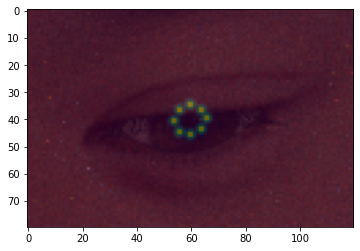

In [96]:
show_heatmaps(plt, eye, hm[0].to("cpu"))

## Soft-argmax 

In [97]:
iterator = iter(test_dataloader)
images, _, _ = next(iterator)
image = images[0].reshape(1, *images[0].shape).to(device)

pupil_landmarks = model(image)
print(image.shape, pupil_landmarks.shape)

NameError: name 'model' is not defined

In [98]:
def softmax(heatmap, temperature):
    with torch.no_grad():
        softmax_map = torch.exp(temperature * heatmap)
        softmax_map = softmax_map / torch.sum(softmax_map)
    return softmax_map

### temperature = 1

In [99]:
def softargmax(heatmap, temperature):
    heatmap = softmax(heatmap, temperature).to(device)
    N, M = heatmap.shape
    x_tensor = torch.full((N, M), 0) + torch.arange(M)
    y_tensor = torch.full((N, M), 0) + torch.arange(N).reshape(-1, 1)
    x_tensor = x_tensor.to(device)
    y_tensor = y_tensor.to(device)
    x = torch.sum(x_tensor * heatmap)
    y = torch.sum(y_tensor * heatmap)
    return (x, y)

In [100]:
N = 3
M = 7

test = torch.full((N, M), 0) + torch.arange(M) 
test

tensor([[0, 1, 2, 3, 4, 5, 6],
        [0, 1, 2, 3, 4, 5, 6],
        [0, 1, 2, 3, 4, 5, 6]])

In [101]:
test = torch.full((N, M), 0) + torch.arange(N).reshape(-1, 1)
test

tensor([[0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1],
        [2, 2, 2, 2, 2, 2, 2]])

RuntimeError: exp_vml_cpu not implemented for 'Long'

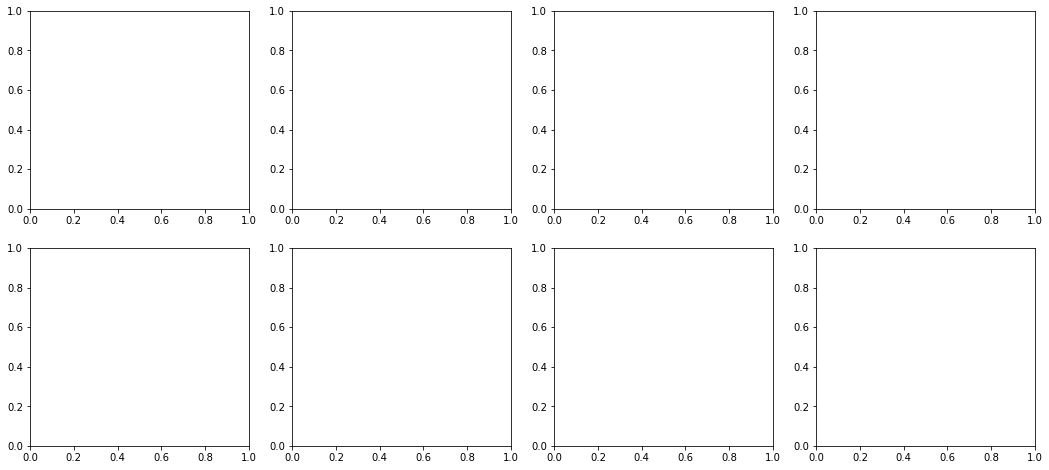

In [102]:
N, M = 2, 4
temperature = 1
fig, ax = plt.subplots(ncols=M, nrows=N, figsize=(18, 8))
for index in range(N * M):
    ax[index // M, index % M].imshow(softmax(pupil_landmarks[0][index].detach().cpu(), temperature).detach().numpy())

### temperature = 5

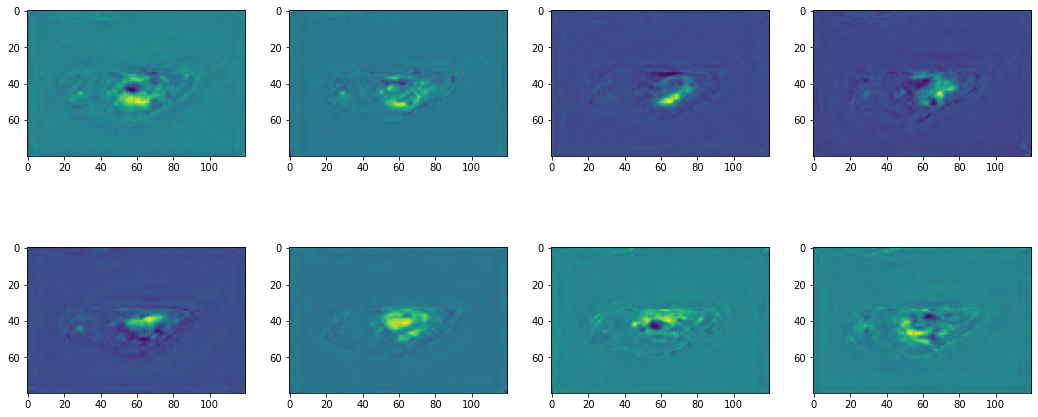

In [34]:
N, M = 2, 4
temperature = 5
fig, ax = plt.subplots(ncols=M, nrows=N, figsize=(18, 8))
for index in range(N * M):
    ax[index // M, index % M].imshow(softmax(pupil_landmarks[0][index].detach().cpu(), temperature).detach().numpy())

### temperature = 15

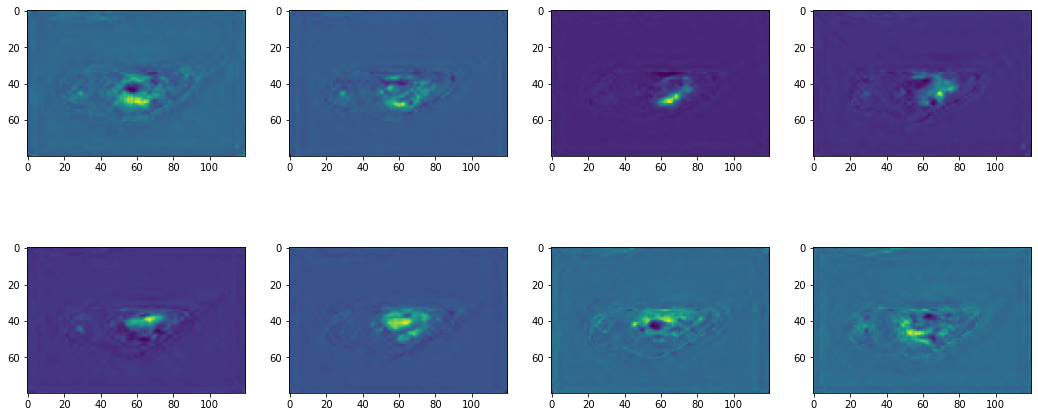

In [35]:
N, M = 2, 4
temperature = 15
fig, ax = plt.subplots(ncols=M, nrows=N, figsize=(18, 8))
for index in range(N * M):
    ax[index // M, index % M].imshow(softmax(pupil_landmarks[0][index].detach().cpu(), temperature).detach().numpy())

In [36]:
heatmaps = model(images.to(device))
print(images.shape, heatmaps.shape)

torch.Size([32, 3, 80, 120]) torch.Size([32, 8, 80, 120])


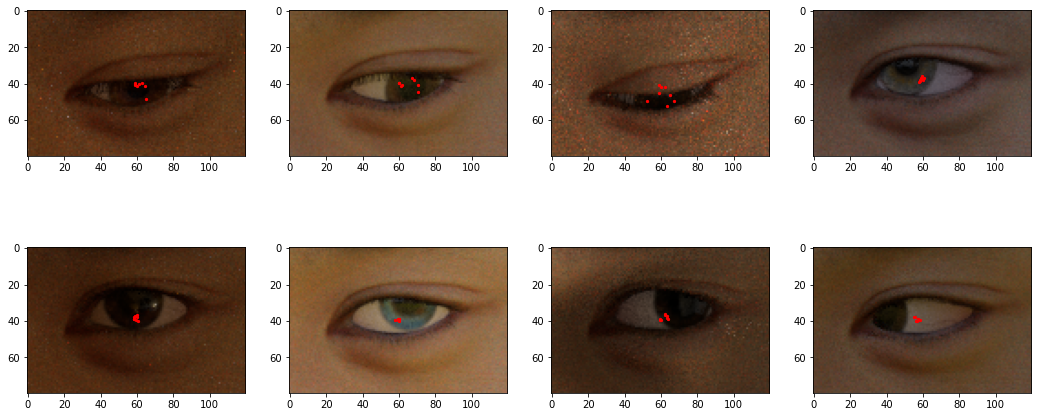

In [37]:
N, M = 2, 4
temperature = 15
fig, ax = plt.subplots(ncols=M, nrows=N, figsize=(18, 8))
for index in range(N * M):
    ax[index // M, index % M].imshow(images[index].permute(1, 2, 0).detach().numpy())
    for hm in heatmaps[index]:
        x, y = softargmax(hm, 100)
        ax[index // M, index % M].scatter(x.item(), y.item(), color='red', s=5)